In [101]:
#Assignment: 01-Function Fitting
#Author: Logan Torgerson
#Due: 9/30/2022

"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a polar stereographic map projection using function fitting.
1. We want to get values for our 500mb height at our grid points by using function fitting on our given observations. 
2. Use different ROIs (10cm and 20cm) to see how this changes our analysis contour maps. 
3. Create contour maps that display how many observations are being used for our analysis points. 
4. Analyze and compare/contrast these maps to see how tinkering changes outcomes. 

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [102]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #pandas to open file


In [103]:
### Define Variables ###
xo = 18.9
yo = -6.3
delta_x = 1.27
delta_y = 1.27
phi_o = 60
lambda_o = -115
rho = 637100000        #Converted to centimeters 
map_scale = 1/15000000


### Read in Observations ###
file = open("C:\\Users\\torge\\Documents\\GitHub\\ATSC528_2022\\RAOBs_201903131200.txt", "r")
data = pd.read_csv(file, sep=",")
data[data.columns[1:5]] = data[data.columns[1:5]].astype(float) #Converting the data in the text file into numbers(float). Locations stay as letters.
#print(contents)



In [104]:
### Set up analysis map with a 22x28 rectangular grid of points ###

l = xo+np.arange(22) * delta_x      #making an x,y grid
k = yo+np.arange(28) * delta_y
x_grid, y_grid = np.meshgrid(l, k)

grid_lon = np.arctan(y_grid/x_grid)*(180/np.pi)+lambda_o      #Converting our grid points from x,y to lat,lon so we can overlay it onto a map projection
grid_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_grid/map_scale)**2+(y_grid/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.)))))) 




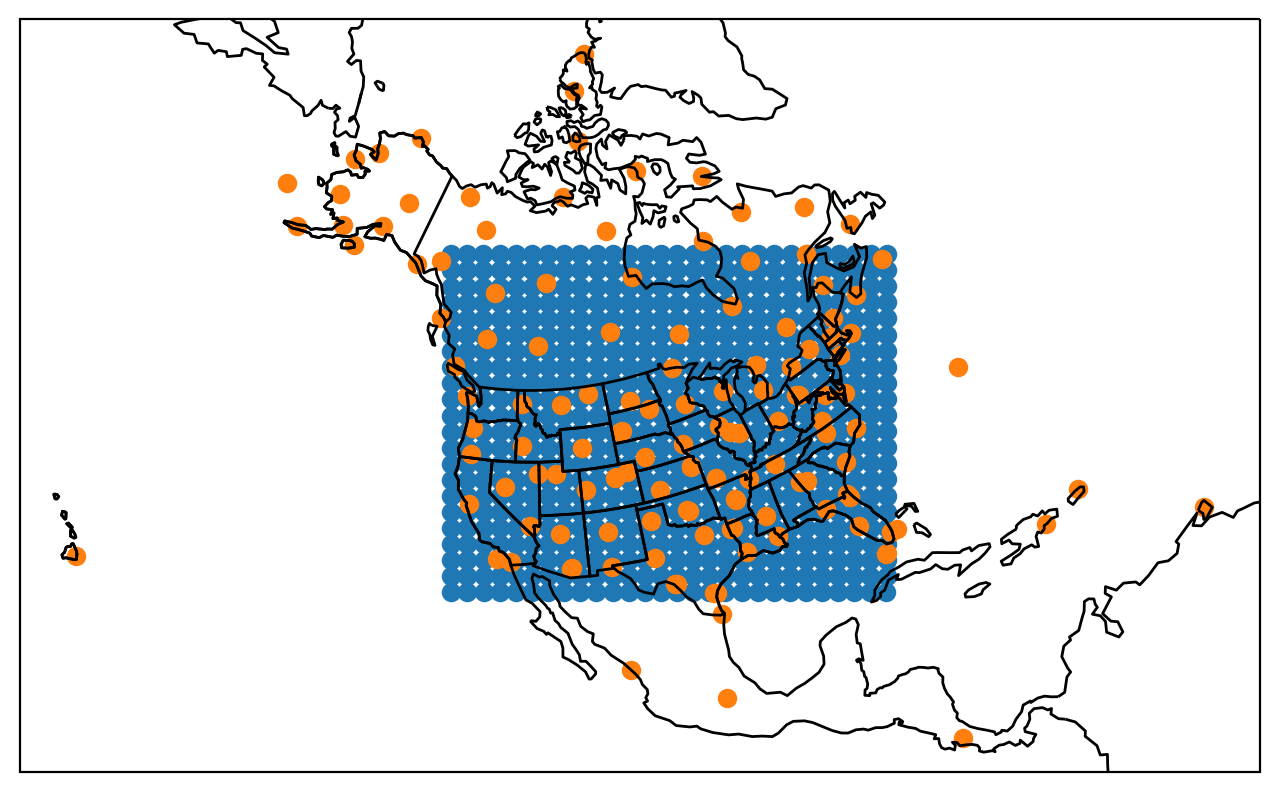

In [105]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###

#Converting our observations from lat,lon to x,y grid because Jared said so
sigma = ((1.0+(np.sin(phi_o*np.pi / 180.))) / (1.0+(np.sin(data['Lat'] * np.pi / 180.))))  #Have to convert to radians for calculation by using pi/180
x = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.cos((data['Lon']-lambda_o) * np.pi / 180.) * map_scale  #Have to multilpy by map scale otherwise values would be in terms of the entire earth
y = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.sin((data['Lon']-lambda_o) * np.pi / 180.) * map_scale

x = np.array(x)     #making our x,y obs into an array to avoid errors
y = np.array(y)

obs_lon = np.arctan(y/x)*(180/np.pi)+lambda_o   #Converting our observations back into lat,lon so we can plot and make sure our grid and overlayed observations are correct
obs_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/map_scale)**2+(y/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.))))))

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(grid_lon.ravel(), grid_lat.ravel(),transform = ccrs.PlateCarree())
ax1.scatter(obs_lon, obs_lat, transform = ccrs.PlateCarree())

plt.savefig("C:\\Users\\torge\\Documents\\GitHub\\ATSC528_2022\\01-Function_Fitting\\Analysis and Obs Field.png")   #Have to save this figure


plt.show()

In [115]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

ROI_arr = np.array([10,20,6])  #making a radius of influence matrix to make our calculations 

x_n = 28                    #defining our matrix size
y_n = 22

#Creating empty matricies to be filled later with our caluclations 
analysis = np.empty((x_n, y_n, len(ROI_arr))) #for the values we calculate 
obs = np.empty((x_n, y_n, len(ROI_arr)))      #for the number of obs being used

#create for loop to fill the matricies with our calculations 
for i in range(len(ROI_arr)):
    roi = ROI_arr[i]
    for m in range(len(x_grid)):
        for n in range(len(x_grid[0])):
            rel_x = x_grid[m,n] - x      #subtracting our obs from our analysis to get a relative distance for our map
            rel_y = y_grid[m,n] - y
            radius = (rel_x**2 + rel_y**2)**(1/2) #radius of influence for our ith analysis point
            index_roi = np.where(radius <=roi)[0] #only obs within roi will affect analysis value
            
            #obs matrix has to be same shape and size as index_roi matrix
            obs[m,n,i] = len(index_roi)
            
            #creating matrices for our f_o(x_k,y_k) using only values within roi
            x_k = rel_x[index_roi]  #x_k values within our R_i for each point
            y_k = rel_y[index_roi]  #y_k values only within index_roi for each grid point
            fo = data['Height'][index_roi] #height values within index_roi values
            fo = np.array(fo)  
            
            #create empty matrices for C=R^-1*0
            R = np.zeros((6,6))
            O = np.zeros(6)
            
            #filling the R matrix
            for q in range(len(y_k)):
                r2 = np.matrix([1,x_k[q],y_k[q],x_k[q]**2,y_k[q]**2,x_k[q]*y_k[q]])
                r1 = r2.T               #.T takes the transpose
                r = r1 * r2
                R += np.array(r)
                O += np.array([fo[q],x_k[q]*fo[q],y_k[q]*fo[q],x_k[q]**2*fo[q],y_k[q]**2*fo[q],x_k[q]*y_k[q]*fo[q]])
                
            #getting average values by dividing by total number of obs used
            R = R/obs[m,n,i]
            O = O/obs[m,n,i]
            
            #calculating C
            C = np.linalg.inv(np.matrix(R))*np.matrix(O).T
            analysis[m,n,i] = C[0,0]
            
            
            


               
              

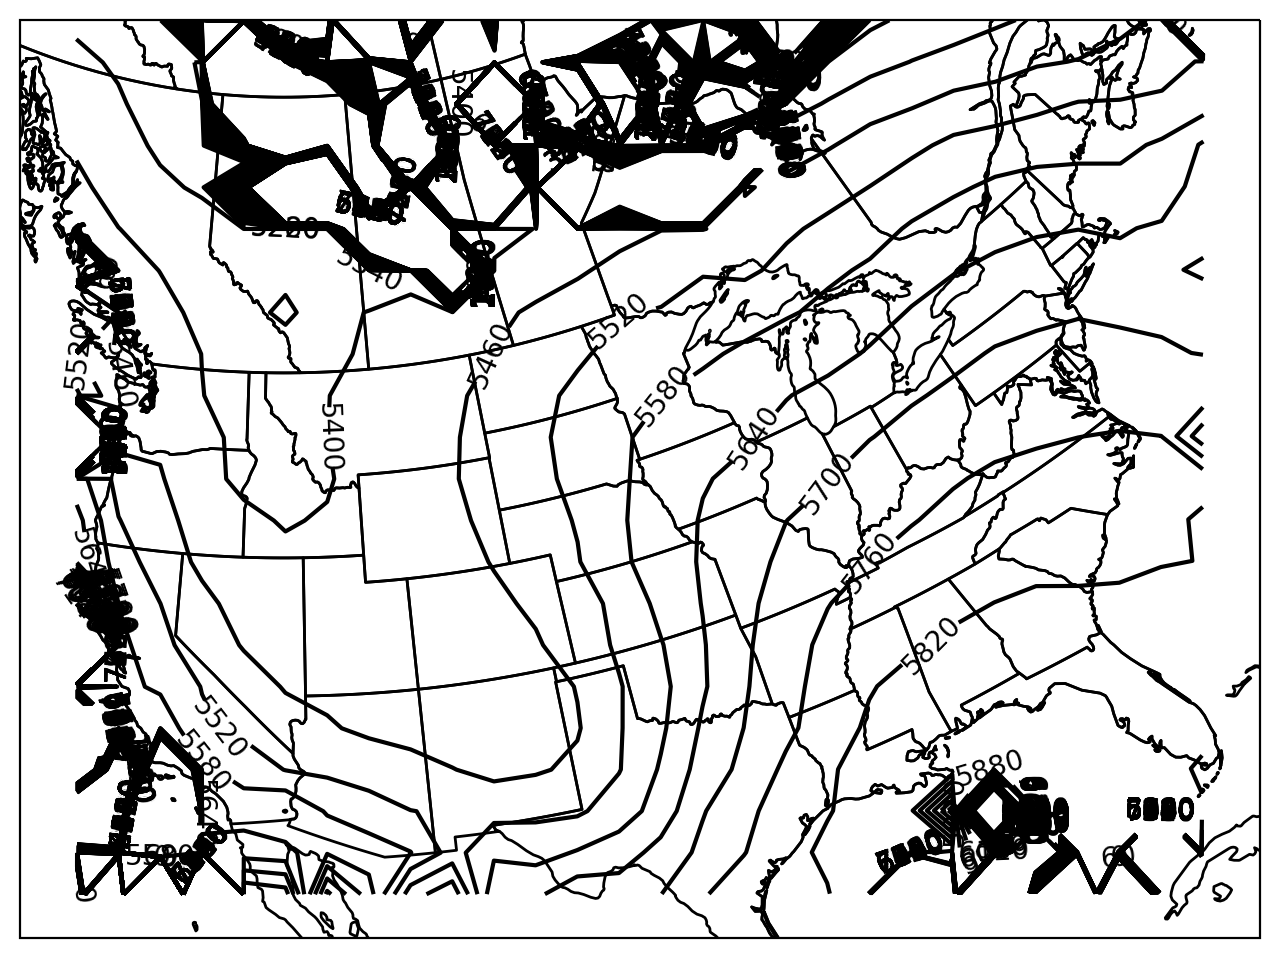

In [114]:
### Plot 500mb analyses over a map ###



proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#we want analysis locations so we plot grid lat/lons not obs lat/lons
cs1 = ax1.contour(grid_lon, grid_lat,analysis[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
#plt.savefig("C:\\Users\\torge\\Documents\\GitHub\\ATSC528_2022\\01-Function_Fitting\\6cm ROI Contour")
plt.show()



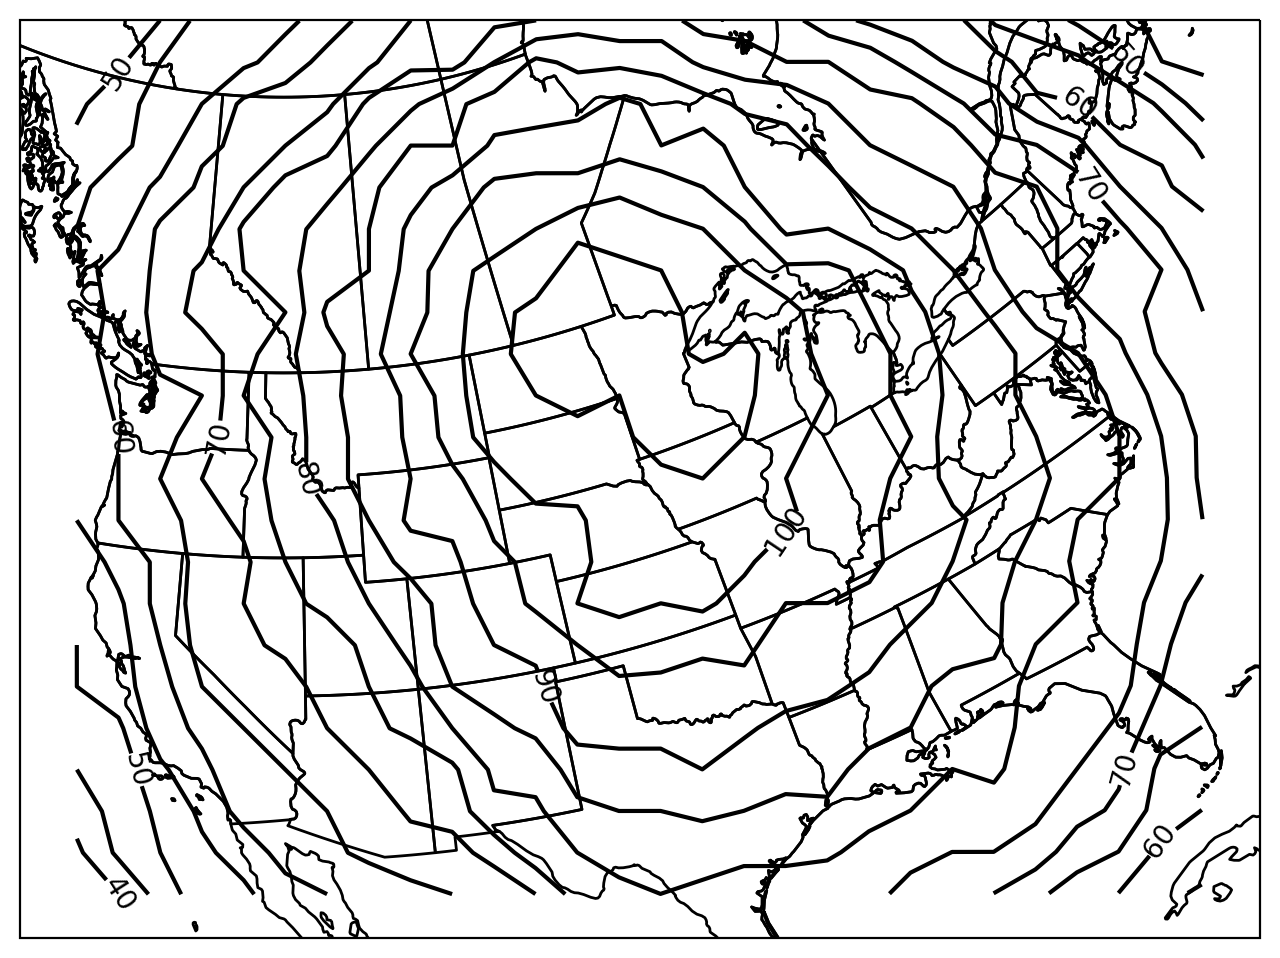

In [108]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations at each grid point
cs1 = ax1.contour(grid_lon,grid_lat,obs[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

#plt.savefig("C:\\Users\\torge\\Documents\\GitHub\\ATSC528_2022\\01-Function_Fitting\\20cm ROI obs_num Contour.png")
plt.show()

In [99]:
### Store the analyses in text files ###

with open('analysis.txt', 'wb') as g:   #outputing to analysis matrix to text files
    for line in analysis:
        np.savetxt(g, line)

In [100]:
### Store the number of observations available for each grid point in text files ###


with open('observations.txt', 'wb') as g:   #outputting observation matrix to text files
    for line in obs:
        np.savetxt(g, line)


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    10cm Contoured Analysis - There is a large negatively tilted trough over the Rocky Mountain region of the US and a pronounced ridge over eastern CONUS.
    There also appears to be a shortwave trough/troughs in the Canadain Provinces of Sakatchewan and Alberta. These dont appear to be part of the main trough
    like the one over Montana does. Judging by the general northern latitudes the 540 line is located it is likely fall/spring. 
    There is also some weird contours near the tip of Florida. These likely don't have any meteorological meaning. 
    
    20cm Contoured Analysis - The main trough over the Rocky Mountain region of CONUS is less negativley tilted than the 10cm and also appears to be weaker 
    with lines like the 5460 not reaching nearly as far south as the 10cm map. Heights are alot lower on the 10cm map. The ridge over eastern CONUS 
    looks similar to the 10cm map with the heights lines being shifted slightly further south. This can be seen with the 5700m contour shifting from
    nothern to central Ohio. The weird contouring near Florida has gone away.
    
    10cm Number of Obs Map - There is a high number of observations per grid point over the Mississippi river area. There is a maximum in observations centered over central 
    Illinois where there is upwards of 50 observations. There are then concentric like circles radiating from this center with decreasing numbers
    of observations. By the time these contours reach the coast of California there are only about 15 oberservations for each gridpoint. In general the 
    eastern CONUS has more obervations per grid point than western CONUS. Grand Forks has about 30 obs per grid point (line practically passes right through).
    
    20cm Number of Obs Map - There is a maximum over Minnesota and Eastern North Dakota where there are upwards of 105 observations per grid point.
    There is a minimum of about 55 obs per grid point along the west coast of California. Concentric circles radiating from the center are seen with
    values decreasing from the center. In general the central CONUS has the most observations per grid point. 
    
    The larger your radius of influence the more smoothed out your contours will be and the smaller your ROI the crazier it will look. Think of high and low pass filtering. 
    
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    Analysis maps- The trough on the 20cm map in the intermountain west is less negatively tilted than on the 10cm map. The trough on the 20cm 
    map is also weaker. For example: the 5460m contour on the 20cm map does not reach nearly as far south as on the 10cm map (Idaho border for
    the 20cm Vs Arizona/New Mexico for the 10cm.) The heights over the southwestern US in general are higher on the 20cm map compared to the 10cm map
    showing that the 20cm depicts a weaker trough. The 20cm map looks to have a smaller but more visible short wave trough over Alberta than the 10cm map.
    The ridge over the eastern CONUS shows much more continuity between the maps with the contours shifted slightly further to the north on the 10cm map. 
    The 5400m contour on the 10cm map takes a dramatic dip to the south that is not seen on the 20cm map. It is hard to tell if this is part of
    the main trough to the south or the shortwave to the north. 
    
    The 20cm map seems to be smoother than the 10cm map. The reason is probably similar to band pass filtering we discussed early in the class.
    When we use a larger ROI we are more likely to smooth out variations in the measurements, whereas when we use a smaller ROI those small 
    variations are more likely to be "preserved". Example: If I was to plot a quarterbacks performance against the league average for one game
    there will likely be large variations. If I were to do the same over the QBs entire career there numbers will likely line up much better with
    league average. The longer the time period I look at the higher the probability he will be "smoothed out" and align closer to league average. 
    
    
    Obs maps- The highest obs per grid point region shifts to the north and west when going from the 10 to 20cm contours. The observations used
    on the 20cm map is much greater than those on the 10cm map. Even the lowest values on the 20cm map are nearly greater than the largest values
    on the 10cm map. This makes physical sense as a larger radius will naturally unclude more observations. The contours on the 20cm map are
    much more closely spaced than those on the 10cm map even though the contour step is the same (5). There does not seem to be any significant difference
    in the smoothness of the contours. 

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    Most of the plot looks similar to the 10 and 20cm plots. When you look at the regions with fewer observations the plot goes crazy and is 
    definitely not realistic. The trough becomes even more negatively tilted creating a trend of becomeing more negativley tilted as we 
    decreased the ROI. There are three regions, Gulf of Mexico, Pacific Coast, and Canada that have very wrong contours. These are also the regions 
    with the least amount of observations. Since the areas such as these have less observations, bad observations can have more weight that negativly
    affects your analysis. As we learned in class the more observations you have to less error your analysis will have, therefore the regions with
    fewer observations are going to have more error. 
    If you look at the observation map for the 6cm ROI the values are much lower than for the 10cm and 20cm maps. The contours also struggle as
    there are many illegal contours such as crossing and loops on the map. It doesn't seem like the 6cm ROI feeds the program enough information
    to make a good contour analysis map.
    
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    As an expirement we ran the code with smaller and smaller ROIs until we got a division by zero error. This was because our ROI was too small
    and some grid points had no observations. In this question we get to assume each grid point would always have 1 obs so we would not have 
    to worry about this error. The determinant of the obs matrix would be zero but we don't take the determinant of this matrix anywhere. 
    This obs matrix does divide the R matrix to get an average value, this is fine as dividing by 1 is obviously legal. For these reasons I
    believe the matrix inversion should be legal. However, as we saw with the 6cm ROI map, this contour plot would probably look terrible and
    be of no use. If you thought the 6cm map was bad, this one would probably be much worse. 
   
'''
